In [1]:
import torch
from torch.autograd import Variable
import torch.nn.functional as F
from torch.utils import data
from torch import nn 
import copy

from tqdm import tqdm
import matplotlib.pyplot as plt
import numpy as np

import pandas as pd
from time import time
from sklearn.metrics import roc_auc_score, average_precision_score, f1_score, roc_curve, confusion_matrix, precision_score, recall_score, auc
from sklearn.model_selection import KFold
torch.manual_seed(1)    # reproducible torch:2 np:3
np.random.seed(1)

from config import BIN_config_DBPE
from models import BIN_Interaction_Flat
from stream import BIN_Data_Encoder

use_cuda = torch.cuda.is_available()
device = torch.device("cuda:0" if use_cuda else "cpu")

In [2]:
import sys
print(sys.executable)

/home/zdx/.pyenv/versions/meta-rl/bin/python


In [4]:
def test(data_generator, model):
    y_pred = []
    y_label = []
    model.eval()
    loss_accumulate = 0.0
    count = 0.0
    for i, (d, p, d_mask, p_mask, label) in enumerate(data_generator):
        score = model(d.long().cuda(), p.long().cuda(), d_mask.long().cuda(), p_mask.long().cuda())
        
        m = torch.nn.Sigmoid()
        logits = torch.squeeze(m(score))
        
        loss_fct = torch.nn.BCELoss()            
        
        label = Variable(torch.from_numpy(np.array(label)).float()).cuda()

        loss = loss_fct(logits, label)
        
        loss_accumulate += loss
        count += 1
        
        logits = logits.detach().cpu().numpy()
        
        label_ids = label.to('cpu').numpy()
        y_label = y_label + label_ids.flatten().tolist()
        y_pred = y_pred + logits.flatten().tolist()
        
    loss = loss_accumulate/count
    
    fpr, tpr, thresholds = roc_curve(y_label, y_pred)

    precision = tpr / (tpr + fpr)

    f1 = 2 * precision * tpr / (tpr + precision + 0.00001)

    thred_optim = thresholds[5:][np.argmax(f1[5:])]

    print("optimal threshold: " + str(thred_optim))

    y_pred_s = [1 if i else 0 for i in (y_pred >= thred_optim)]

    auc_k = auc(fpr, tpr)
    print("AUROC:" + str(auc_k))
    print("AUPRC: "+ str(average_precision_score(y_label, y_pred)))

    cm1 = confusion_matrix(y_label, y_pred_s)
    print('Confusion Matrix : \n', cm1)
    print('Recall : ', recall_score(y_label, y_pred_s))
    print('Precision : ', precision_score(y_label, y_pred_s))

    total1=sum(sum(cm1))
    #####from confusion matrix calculate accuracy
    accuracy1=(cm1[0,0]+cm1[1,1])/total1
    print ('Accuracy : ', accuracy1)

    sensitivity1 = cm1[0,0]/(cm1[0,0]+cm1[0,1])
    print('Sensitivity : ', sensitivity1 )

    specificity1 = cm1[1,1]/(cm1[1,0]+cm1[1,1])
    print('Specificity : ', specificity1)

    outputs = np.asarray([1 if i else 0 for i in (np.asarray(y_pred) >= 0.5)])
    return roc_auc_score(y_label, y_pred), average_precision_score(y_label, y_pred), f1_score(y_label, outputs), y_pred, loss.item()


def main(fold_n, lr):
    config = BIN_config_DBPE()
    
    lr = lr
    BATCH_SIZE = config['batch_size']
    train_epoch = 10
    
    loss_history = []
    
    model = BIN_Interaction_Flat(**config)
    
    model = model.cuda()

    if torch.cuda.device_count() > 1:
        print("Let's use", torch.cuda.device_count(), "GPUs!")
        model = nn.DataParallel(model, dim = 0)
            
    opt = torch.optim.Adam(model.parameters(), lr = lr)
    #opt = torch.optim.SGD(model.parameters(), lr = lr, momentum=0.9)
    
    print('--- Data Preparation ---')
    
    params = {'batch_size': BATCH_SIZE,
              'shuffle': True,
              'num_workers': 6, 
              'drop_last': True}

    dataFolder = './dataset/BindingDB'
    df_train = pd.read_csv(dataFolder + '/train.csv')
    df_val = pd.read_csv(dataFolder + '/val.csv')
    df_test = pd.read_csv(dataFolder + '/test.csv')
    
    training_set = BIN_Data_Encoder(df_train.indjex.values, df_train.Label.values, df_train)
    training_generator = data.DataLoader(training_set, **params)

    validation_set = BIN_Data_Encoder(df_val.index.values, df_val.Label.values, df_val)
    validation_generator = data.DataLoader(validation_set, **params)
    
    testing_set = BIN_Data_Encoder(df_test.index.values, df_test.Label.values, df_test)
    testing_generator = data.DataLoader(testing_set, **params)
    
    # early stopping
    max_auc = 0
    model_max = copy.deepcopy(model)
    
    print('--- Go for Training ---')
    torch.backends.cudnn.benchmark = True
    for epo in range(train_epoch):
        model.train()
        for i, (d, p, d_mask, p_mask, label) in enumerate(training_generator):
            score = model(d.long().cuda(), p.long().cuda(), d_mask.long().cuda(), p_mask.long().cuda())

            label = Variable(torch.from_numpy(np.array(label)).float()).cuda()
            
            loss_fct = torch.nn.BCELoss()
            m = torch.nn.Sigmoid()
            n = torch.squeeze(m(score))
            
            loss = loss_fct(n, label)
            loss_history.append(loss)
            
            opt.zero_grad()
            loss.backward()
            opt.step()
            
            if (i % 100 == 0):
                print('Training at Epoch ' + str(epo + 1) + ' iteration ' + str(i) + ' with loss ' + str(loss.cpu().detach().numpy()))
            
        # every epoch test
        with torch.set_grad_enabled(False):
            auc, auprc, f1, logits, loss = test(validation_generator, model)
            if auc > max_auc:
                model_max = copy.deepcopy(model)
                max_auc = auc
            
            print('Validation at Epoch '+ str(epo + 1) + ' , AUROC: '+ str(auc) + ' , AUPRC: ' + str(auprc) + ' , F1: '+str(f1))
    
    print('--- Go for Testing ---')
    try:
        with torch.set_grad_enabled(False):
            auc, auprc, f1, logits, loss = test(testing_generator, model_max)
            print('Testing AUROC: ' + str(auc) + ' , AUPRC: ' + str(auprc) + ' , F1: '+str(f1) + ' , Test loss: '+str(loss))
    except:
        print('testing failed')
    return model_max, loss_history

--- Data Preparation ---
--- Go for Training ---
Training at Epoch 1 iteration 0 with loss 0.6871528
Training at Epoch 1 iteration 100 with loss 0.81716734
Training at Epoch 1 iteration 200 with loss 0.60536927
Training at Epoch 1 iteration 300 with loss 0.81561315
Training at Epoch 1 iteration 400 with loss 0.5608501
Training at Epoch 1 iteration 500 with loss 0.6886791
Training at Epoch 1 iteration 600 with loss 0.59586835
Training at Epoch 1 iteration 700 with loss 0.67609274
Training at Epoch 1 iteration 800 with loss 0.6344186
Training at Epoch 1 iteration 900 with loss 0.6722579
Training at Epoch 1 iteration 1000 with loss 0.638059
Training at Epoch 1 iteration 1100 with loss 0.48087722
Training at Epoch 1 iteration 1200 with loss 0.59553003
Training at Epoch 1 iteration 1300 with loss 0.5529174
Training at Epoch 1 iteration 1400 with loss 0.67067695
Training at Epoch 1 iteration 1500 with loss 0.4577648
Training at Epoch 1 iteration 1600 with loss 0.6020538
Training at Epoch 1 i

/home/zdx/.pyenv/versions/meta-rl/lib/python3.7/site-packages/ipykernel/__main__.py:32: RuntimeWarning: invalid value encountered in true_divide


Training at Epoch 2 iteration 0 with loss 0.51962197
Training at Epoch 2 iteration 100 with loss 0.52024114
Training at Epoch 2 iteration 200 with loss 0.7717838
Training at Epoch 2 iteration 300 with loss 0.750285
Training at Epoch 2 iteration 400 with loss 0.5697961
Training at Epoch 2 iteration 500 with loss 0.40790504
Training at Epoch 2 iteration 600 with loss 0.5260252
Training at Epoch 2 iteration 700 with loss 0.51975924
Training at Epoch 2 iteration 800 with loss 0.45560312
Training at Epoch 2 iteration 900 with loss 0.692677
Training at Epoch 2 iteration 1000 with loss 0.8300811
Training at Epoch 2 iteration 1100 with loss 0.47024906
Training at Epoch 2 iteration 1200 with loss 0.52743983
Training at Epoch 2 iteration 1300 with loss 0.82229483
Training at Epoch 2 iteration 1400 with loss 0.38334316
Training at Epoch 2 iteration 1500 with loss 0.43084177
Training at Epoch 2 iteration 1600 with loss 0.45551434
Training at Epoch 2 iteration 1700 with loss 0.7743418
Training at E

/home/zdx/.pyenv/versions/meta-rl/lib/python3.7/site-packages/ipykernel/__main__.py:32: RuntimeWarning: invalid value encountered in true_divide


Training at Epoch 3 iteration 0 with loss 0.54710495
Training at Epoch 3 iteration 100 with loss 0.52779245
Training at Epoch 3 iteration 200 with loss 0.5745724
Training at Epoch 3 iteration 300 with loss 0.53866446
Training at Epoch 3 iteration 400 with loss 0.3905522
Training at Epoch 3 iteration 500 with loss 0.81826794
Training at Epoch 3 iteration 600 with loss 0.36612353
Training at Epoch 3 iteration 700 with loss 0.34689963
Training at Epoch 3 iteration 800 with loss 0.56949043
Training at Epoch 3 iteration 900 with loss 0.37182528
Training at Epoch 3 iteration 1000 with loss 0.3675472
Training at Epoch 3 iteration 1100 with loss 0.5133009
Training at Epoch 3 iteration 1200 with loss 0.5902873
Training at Epoch 3 iteration 1300 with loss 0.67270446
Training at Epoch 3 iteration 1400 with loss 0.5616305
Training at Epoch 3 iteration 1500 with loss 0.38696176
Training at Epoch 3 iteration 1600 with loss 0.46595845
Training at Epoch 3 iteration 1700 with loss 0.5107467
Training at

/home/zdx/.pyenv/versions/meta-rl/lib/python3.7/site-packages/ipykernel/__main__.py:32: RuntimeWarning: invalid value encountered in true_divide


Training at Epoch 4 iteration 0 with loss 0.8484693
Training at Epoch 4 iteration 100 with loss 0.38970795
Training at Epoch 4 iteration 200 with loss 0.433564
Training at Epoch 4 iteration 300 with loss 0.75303715
Training at Epoch 4 iteration 400 with loss 0.3741634
Training at Epoch 4 iteration 500 with loss 0.562875
Training at Epoch 4 iteration 600 with loss 0.37542123
Training at Epoch 4 iteration 700 with loss 0.581832
Training at Epoch 4 iteration 800 with loss 0.42504066
Training at Epoch 4 iteration 900 with loss 0.6865419
Training at Epoch 4 iteration 1000 with loss 0.7631142
Training at Epoch 4 iteration 1100 with loss 0.90158474
Training at Epoch 4 iteration 1200 with loss 0.30134374
Training at Epoch 4 iteration 1300 with loss 0.56051755
Training at Epoch 4 iteration 1400 with loss 0.64133286
Training at Epoch 4 iteration 1500 with loss 0.66662556
Training at Epoch 4 iteration 1600 with loss 0.43326062
Training at Epoch 4 iteration 1700 with loss 0.5318059
Training at Epo

/home/zdx/.pyenv/versions/meta-rl/lib/python3.7/site-packages/ipykernel/__main__.py:32: RuntimeWarning: invalid value encountered in true_divide


Training at Epoch 5 iteration 0 with loss 0.32406163
Training at Epoch 5 iteration 100 with loss 0.34840214
Training at Epoch 5 iteration 200 with loss 0.82498133
Training at Epoch 5 iteration 300 with loss 0.4349893
Training at Epoch 5 iteration 400 with loss 0.8417536
Training at Epoch 5 iteration 500 with loss 0.9277842
Training at Epoch 5 iteration 600 with loss 0.25983262
Training at Epoch 5 iteration 700 with loss 0.45074826
Training at Epoch 5 iteration 800 with loss 0.34419656
Training at Epoch 5 iteration 900 with loss 0.8725661
Training at Epoch 5 iteration 1000 with loss 0.77098227
Training at Epoch 5 iteration 1100 with loss 0.48937577
Training at Epoch 5 iteration 1200 with loss 0.45705077
Training at Epoch 5 iteration 1300 with loss 0.63410544
Training at Epoch 5 iteration 1400 with loss 0.41360217
Training at Epoch 5 iteration 1500 with loss 0.64831096
Training at Epoch 5 iteration 1600 with loss 0.43756318
Training at Epoch 5 iteration 1700 with loss 1.3613306
Training 

/home/zdx/.pyenv/versions/meta-rl/lib/python3.7/site-packages/ipykernel/__main__.py:32: RuntimeWarning: invalid value encountered in true_divide


Training at Epoch 6 iteration 0 with loss 0.4470876
Training at Epoch 6 iteration 100 with loss 0.35323423
Training at Epoch 6 iteration 200 with loss 0.49431992
Training at Epoch 6 iteration 300 with loss 0.35381103
Training at Epoch 6 iteration 400 with loss 0.8781048
Training at Epoch 6 iteration 500 with loss 0.2780304
Training at Epoch 6 iteration 600 with loss 0.26082212
Training at Epoch 6 iteration 700 with loss 0.42571923
Training at Epoch 6 iteration 800 with loss 0.48676598
Training at Epoch 6 iteration 900 with loss 0.36938953
Training at Epoch 6 iteration 1000 with loss 0.365251
Training at Epoch 6 iteration 1100 with loss 0.6070029
Training at Epoch 6 iteration 1200 with loss 0.7963381
Training at Epoch 6 iteration 1300 with loss 0.3607612
Training at Epoch 6 iteration 1400 with loss 0.41258818
Training at Epoch 6 iteration 1500 with loss 0.9541172
Training at Epoch 6 iteration 1600 with loss 0.65979743
Training at Epoch 6 iteration 1700 with loss 0.6285771
Training at Ep

/home/zdx/.pyenv/versions/meta-rl/lib/python3.7/site-packages/ipykernel/__main__.py:32: RuntimeWarning: invalid value encountered in true_divide


Training at Epoch 7 iteration 0 with loss 0.27598897
Training at Epoch 7 iteration 100 with loss 0.36331037
Training at Epoch 7 iteration 200 with loss 0.39220363
Training at Epoch 7 iteration 300 with loss 0.31749249
Training at Epoch 7 iteration 400 with loss 0.500906
Training at Epoch 7 iteration 500 with loss 0.58215576
Training at Epoch 7 iteration 600 with loss 0.31948668
Training at Epoch 7 iteration 700 with loss 0.24961579
Training at Epoch 7 iteration 800 with loss 0.22053972
Training at Epoch 7 iteration 900 with loss 0.91278183
Training at Epoch 7 iteration 1000 with loss 0.3854853
Training at Epoch 7 iteration 1100 with loss 0.60668933
Training at Epoch 7 iteration 1200 with loss 0.4602598
Training at Epoch 7 iteration 1300 with loss 0.68827295
Training at Epoch 7 iteration 1400 with loss 0.22113997
Training at Epoch 7 iteration 1500 with loss 0.27772754
Training at Epoch 7 iteration 1600 with loss 0.3963105
Training at Epoch 7 iteration 1700 with loss 0.50470126
Training 

/home/zdx/.pyenv/versions/meta-rl/lib/python3.7/site-packages/ipykernel/__main__.py:32: RuntimeWarning: invalid value encountered in true_divide


Training at Epoch 8 iteration 0 with loss 0.19746466
Training at Epoch 8 iteration 100 with loss 0.55472654
Training at Epoch 8 iteration 200 with loss 0.35665208
Training at Epoch 8 iteration 300 with loss 0.36032104
Training at Epoch 8 iteration 400 with loss 0.22986762
Training at Epoch 8 iteration 500 with loss 0.4929989
Training at Epoch 8 iteration 600 with loss 0.37819165
Training at Epoch 8 iteration 700 with loss 0.33332014
Training at Epoch 8 iteration 800 with loss 0.43352863
Training at Epoch 8 iteration 900 with loss 0.6094138
Training at Epoch 8 iteration 1000 with loss 0.4214249
Training at Epoch 8 iteration 1100 with loss 0.52009976
Training at Epoch 8 iteration 1200 with loss 0.53572273
Training at Epoch 8 iteration 1300 with loss 0.21465409
Training at Epoch 8 iteration 1400 with loss 0.6888572
Training at Epoch 8 iteration 1500 with loss 0.36735356
Training at Epoch 8 iteration 1600 with loss 0.62447417
Training at Epoch 8 iteration 1700 with loss 0.32431507
Training

/home/zdx/.pyenv/versions/meta-rl/lib/python3.7/site-packages/ipykernel/__main__.py:32: RuntimeWarning: invalid value encountered in true_divide


Training at Epoch 9 iteration 0 with loss 0.57086855
Training at Epoch 9 iteration 100 with loss 1.0267323
Training at Epoch 9 iteration 200 with loss 0.3175819
Training at Epoch 9 iteration 300 with loss 0.47214982
Training at Epoch 9 iteration 400 with loss 0.6876374
Training at Epoch 9 iteration 500 with loss 0.54324603
Training at Epoch 9 iteration 600 with loss 0.2655022
Training at Epoch 9 iteration 700 with loss 0.7457869
Training at Epoch 9 iteration 800 with loss 0.41463327
Training at Epoch 9 iteration 900 with loss 0.32027906
Training at Epoch 9 iteration 1000 with loss 0.6011503
Training at Epoch 9 iteration 1100 with loss 0.46313846
Training at Epoch 9 iteration 1200 with loss 0.7054145
Training at Epoch 9 iteration 1300 with loss 0.24095881
Training at Epoch 9 iteration 1400 with loss 0.59641695
Training at Epoch 9 iteration 1500 with loss 0.9727119
Training at Epoch 9 iteration 1600 with loss 0.14912638
Training at Epoch 9 iteration 1700 with loss 0.35522285
Training at 

/home/zdx/.pyenv/versions/meta-rl/lib/python3.7/site-packages/ipykernel/__main__.py:32: RuntimeWarning: invalid value encountered in true_divide


Training at Epoch 10 iteration 0 with loss 0.3108026
Training at Epoch 10 iteration 100 with loss 0.20334767
Training at Epoch 10 iteration 200 with loss 0.34976935
Training at Epoch 10 iteration 300 with loss 0.1901992
Training at Epoch 10 iteration 400 with loss 0.5104041
Training at Epoch 10 iteration 500 with loss 1.2161007
Training at Epoch 10 iteration 600 with loss 0.3761418
Training at Epoch 10 iteration 700 with loss 0.37896463
Training at Epoch 10 iteration 800 with loss 0.92417085
Training at Epoch 10 iteration 900 with loss 0.52304196
Training at Epoch 10 iteration 1000 with loss 0.17293215
Training at Epoch 10 iteration 1100 with loss 0.893134
Training at Epoch 10 iteration 1200 with loss 0.23694442
Training at Epoch 10 iteration 1300 with loss 0.2986547
Training at Epoch 10 iteration 1400 with loss 0.3254029
Training at Epoch 10 iteration 1500 with loss 0.6660339
Training at Epoch 10 iteration 1600 with loss 0.34580365
Training at Epoch 10 iteration 1700 with loss 0.31795

/home/zdx/.pyenv/versions/meta-rl/lib/python3.7/site-packages/ipykernel/__main__.py:32: RuntimeWarning: invalid value encountered in true_divide
/home/zdx/.pyenv/versions/meta-rl/lib/python3.7/site-packages/ipykernel/__main__.py:32: RuntimeWarning: invalid value encountered in true_divide


optimal threshold: 0.38340646028518677
AUROC:0.8684323424695342
AUPRC: 0.5230513730279391
Confusion Matrix : 
 [[8030 3353]
 [ 205 1700]]
Recall :  0.8923884514435696
Precision :  0.33643380170195925
Accuracy :  0.7322396146899458
Sensitivity :  0.7054379337608715
Specificity :  0.8923884514435696
Testing AUROC: 0.8684323424695342 , AUPRC: 0.5230513730279391 , F1: 0.5259831460674157 , Test loss: 0.47883719205856323
1572.3170115947723


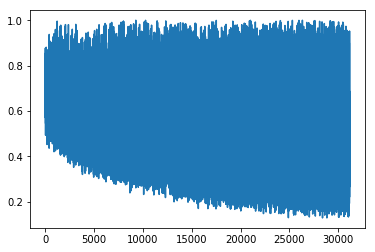

In [5]:
# fold 1
#biosnap interaction times 1e-6, flat, batch size 64, len 205, channel 3, epoch 50
s = time()
model_max, loss_history = main(1, 5e-6)
e = time()
print(e-s)
lh = list(filter(lambda x: x < 1, loss_history))
plt.plot(lh)

In [3]:
torch.tensor([1.0, 2.0]).cuda()

tensor([1., 2.], device='cuda:0')

In [4]:
print(torch.__version__)

1.11.0.dev20211106+cu113


In [23]:
config = BIN_config_DBPE()

BATCH_SIZE = config['batch_size']

params = {'batch_size': BATCH_SIZE,
              'shuffle': True,
              'num_workers': 6, 
              'drop_last': True}

dataFolder = './dataset/BIOSNAP/full_data'
df_train = pd.read_csv(dataFolder + '/train.csv')
df_val = pd.read_csv(dataFolder + '/val.csv')
df_test = pd.read_csv(dataFolder + '/test.csv')

training_set = BIN_Data_Encoder(df_train.index.values, df_train.Label.values, df_train)
training_generator = data.DataLoader(training_set, **params)

In [24]:
df_train.head()

,Unnamed: 0,Unnamed: 0.1,Unnamed: 0.1.1,DrugBank ID,Gene,Label,SMILES,Target Sequence
0,0,3,4,DB08533,P49862,0.0,CC1=CN=C2N1C=CN=C2NCC1=CC=NC=C1,MARSLLLPLQILLLSLALETAGEEAQGDKIIDGAPCARGSHPWQVA...
1,1,4,5,DB00755,P48443,1.0,C\C(\C=C\C1=C(C)CCCC1(C)C)=C/C=C/C(/C)=C/C(O)=O,MYGNYSHFMKFPAGYGGSPGHTGSTSMSPSAALSTGKPMDSHPSYT...
2,2,5,6,DB00361,O60218,0.0,[H][C@@]12N(C)C3=CC(OC)=C(C=C3[C@@]11CCN3CC=C[...,MATFVELSTKAKMPIVGLGTWKSPLGKVKEAVKVAIDAGYRHIDCA...
3,3,7,8,DB01136,P08588,1.0,COC1=CC=CC=C1OCCNCC(O)COC1=CC=CC2=C1C1=CC=CC=C1N2,MGAGVLVLGASEPGNLSSAAPLPDGAATAARLLVPASPPASLLPPA...
4,4,8,9,DB06963,Q9Y691,0.0,[H][C@@](C)(NC1=CC2=C(C=N1)C(C)=NN2C1=CC=CC(CC...,MFIWTSGRTSSSYRHDEKRNIYQKIRDHDLLDKRKTVTALKAGEDR...


In [25]:
df_train["drug_encoding"][0]

KeyError: 'drug_encoding'

In [26]:
for i, (d, p, d_mask, p_mask, label) in enumerate(training_generator):
    print("DRUG:")
    print(d.shape)
    print(d)
    print("PROTEIN:")
    print(p.shape)
    print(p)
    print("DRUG MASK:")
    print(d_mask)
    print("PROTEIN MASK:")
    print(p_mask)
    print("LABEL")
    print(label.shape)
    print(label)
    break

DRUG:
torch.Size([16, 50])
tensor([[ 3291,   300,   471,   117,  7522,  1804,   147,  2268,    91,  1855,
            82,   211,   623,     0,     0,     0,     0,     0,     0,     0,
             0,     0,     0,     0,     0,     0,     0,     0,     0,     0,
             0,     0,     0,     0,     0,     0,     0,     0,     0,     0,
             0,     0,     0,     0,     0,     0,     0,     0,     0,     0],
        [    7,    66,  5763,    63,  3821, 13901,     7,    66,    11,  3901,
             7,    66,   189,  5374,   156,    10,     7,    66,    11,  1077,
          1176,     0,     0,     0,     0,     0,     0,     0,     0,     0,
             0,     0,     0,     0,     0,     0,     0,     0,     0,     0,
             0,     0,     0,     0,     0,     0,     0,     0,     0,     0],
        [10440, 18363,  6525, 20141,   569,     0,     0,     0,     0,     0,
             0,     0,     0,     0,     0,     0,     0,     0,     0,     0,
             0,     0, 